# Cass-Koopmans Planning Problem

In [1]:
from numba import njit, jitclass, float64
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
planning_data = [
    ('γ', float64),    # Coefficient of relative risk aversion
    ('β', float64),    # Discount factor
    ('δ', float64),    # Depreciation rate on capital
    ('α', float64),    # Return to capital per capita
    ('A', float64)     # Technology
]

In [3]:
@jitclass(planning_data)
class PlanningProblem():

    def __init__(self, γ=2, β=0.95, δ=0.02, α=0.33, A=1):

        self.γ, self.β = γ, β
        self.δ, self.α, self.A = δ, α, A

    def u(self, c):
        '''
        Utility function
        ASIDE: If you have a utility function that is hard to solve by hand
        you can use automatic or symbolic differentiation
        See https://github.com/HIPS/autograd
        '''
        γ = self.γ

        return c ** (1 - γ) / (1 - γ) if γ!= 1 else np.log(c)

    def u_prime(self, c):
        'Derivative of utility'
        γ = self.γ

        return c ** (-γ)

    def u_prime_inv(self, c):
        'Inverse of derivative of utility'
        γ = self.γ

        return c ** (-1 / γ)

    def f(self, k):
        'Production function'
        α, A = self.α, self.A

        return A * k ** α

    def f_prime(self, k):
        'Derivative of production function'
        α, A = self.α, self.A

        return α * A * k ** (α - 1)

    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α, A = self.α, self.A

        return (k / (A * α)) ** (1 / (α - 1))

    def next_k_c(self, k, c):
        ''''
        Given the current capital Kt and an arbitrary feasible
        consumption choice Ct, computes Kt+1 by state transition law
        and optimal Ct+1 by Euler equation.
        '''
        β, δ = self.β, self.δ
        u_prime, u_prime_inv = self.u_prime, self.u_prime_inv
        f, f_prime = self.f, self.f_prime

        k_next = f(k) + (1 - δ) * k - c
        c_next = u_prime_inv(u_prime(c) / (β * (f_prime(k_next) + (1 - δ))))

        return k_next, c_next

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  """Entry point for launching an IPython kernel.


In [4]:
pp = PlanningProblem()

In [5]:
@njit
def shooting(pp, c0, k0, T=10):
    '''
    Given the initial condition of capital k0 and an initial guess
    of consumption c0, computes the whole paths of c and k
    using the state transition law and Euler equation for T periods.
    '''
    if c0 > pp.f(k0):
        print("initial consumption is not feasible")

        return None

    # initialize vectors of c and k
    c_vec = np.empty(T+1)
    k_vec = np.empty(T+2)

    c_vec[0] = c0
    k_vec[0] = k0

    for t in range(T):
        k_vec[t+1], c_vec[t+1] = pp.next_k_c(k_vec[t], c_vec[t])

    k_vec[T+1] = pp.f(k_vec[T]) + (1 - pp.δ) * k_vec[T] - c_vec[T]

    return c_vec, k_vec

In [6]:
paths = shooting(pp, 0.2, 0.3, T=10)

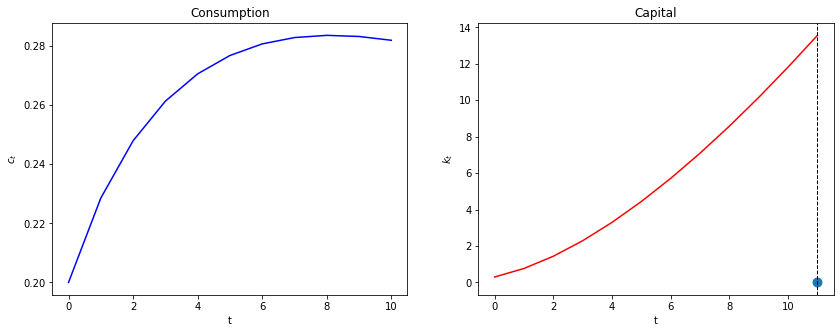

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

colors = ['blue', 'red']
titles = ['Consumption', 'Capital']
ylabels = ['$c_t$', '$k_t$']

T = paths[0].size - 1
for i in range(2):
    axs[i].plot(paths[i], c=colors[i])
    axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

axs[1].scatter(T+1, 0, s=80)
axs[1].axvline(T+1, color='k', ls='--', lw=1)

plt.show()

In [8]:
@njit
def bisection(pp, c0, k0, T=10, tol=1e-4, max_iter=500, k_ter=0, verbose=True):

    # initial boundaries for guess c0
    c0_upper = pp.f(k0)
    c0_lower = 0

    i = 0
    while True:
        c_vec, k_vec = shooting(pp, c0, k0, T)
        error = k_vec[-1] - k_ter

        # check if the terminal condition is satisfied
        if np.abs(error) < tol:
            if verbose:
                print('Converged successfully on iteration ', i+1)
            return c_vec, k_vec

        i += 1
        if i == max_iter:
            if verbose:
                print('Convergence failed.')
            return c_vec, k_vec

        # if iteration continues, updates boundaries and guess of c0
        if error > 0:
            c0_lower = c0
        else:
            c0_upper = c0

        c0 = (c0_lower + c0_upper) / 2

In [9]:
def plot_paths(pp, c0, k0, T_arr, k_ter=0, k_ss=None, axs=None):

    if axs is None:
        fix, axs = plt.subplots(1, 3, figsize=(16, 4))
    ylabels = ['$c_t$', '$k_t$', '$\mu_t$']
    titles = ['Consumption', 'Capital', 'Lagrange Multiplier']

    c_paths = []
    k_paths = []
    for T in T_arr:
        c_vec, k_vec = bisection(pp, c0, k0, T, k_ter=k_ter, verbose=False)
        c_paths.append(c_vec)
        k_paths.append(k_vec)

        μ_vec = pp.u_prime(c_vec)
        paths = [c_vec, k_vec, μ_vec]

        for i in range(3):
            axs[i].plot(paths[i])
            axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

        # Plot steady state value of capital
        if k_ss is not None:
            axs[1].axhline(k_ss, c='k', ls='--', lw=1)

        axs[1].axvline(T+1, c='k', ls='--', lw=1)
        axs[1].scatter(T+1, paths[1][-1], s=80)

    return c_paths, k_paths

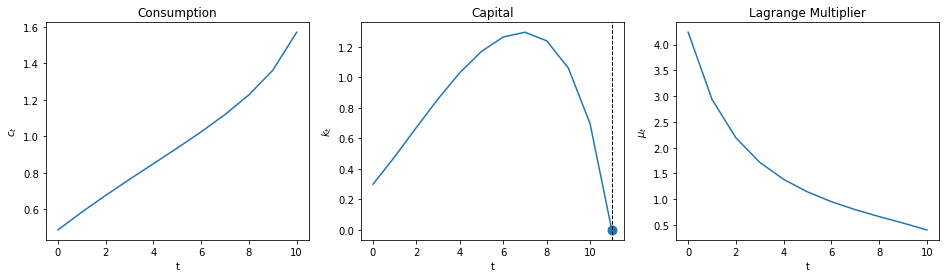

In [10]:
plot_paths(pp, 0.3, 0.3, [10]);

In [11]:
ρ = 1 / pp.β - 1
k_ss = pp.f_prime_inv(ρ+pp.δ)

print(f'steady state for capital is: {k_ss}')

steady state for capital is: 9.57583816331462


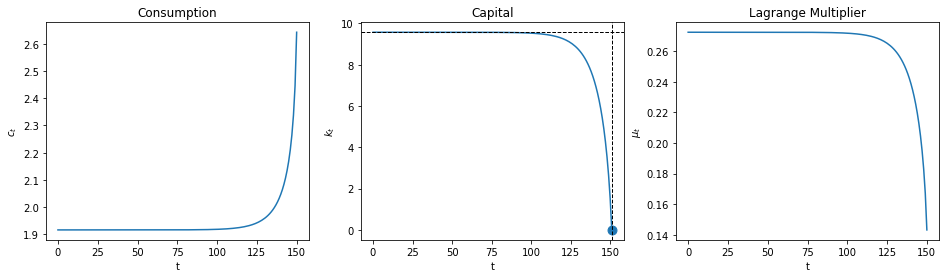

In [12]:
plot_paths(pp, 0.3, k_ss, [150], k_ss=k_ss);

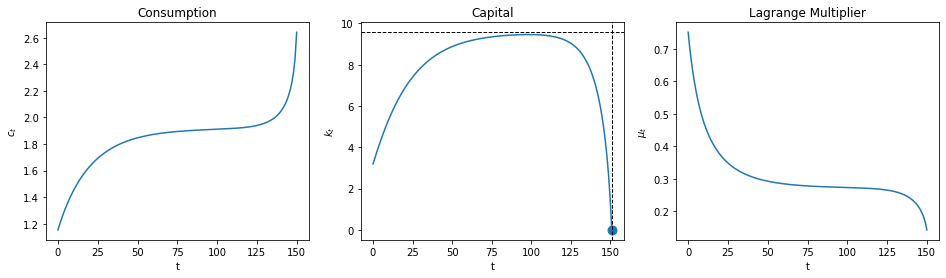

In [13]:
plot_paths(pp, 0.3, k_ss/3, [150], k_ss=k_ss);

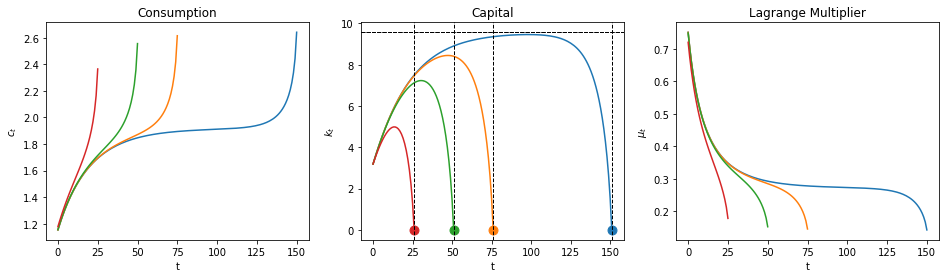

In [14]:
plot_paths(pp, 0.3, k_ss/3, [150, 75, 50, 25], k_ss=k_ss);

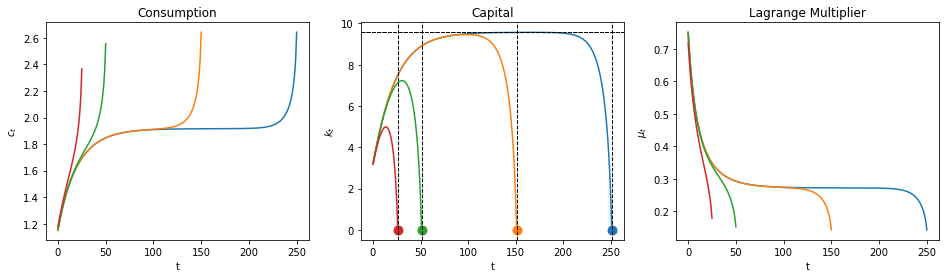

In [15]:
plot_paths(pp, 0.3, k_ss/3, [250, 150, 50, 25], k_ss=k_ss);

In [16]:
@njit
def saving_rate(pp, c_path, k_path):
    'Given paths of c and k, computes the path of saving rate.'
    production = pp.f(k_path[:-1])

    return (production - c_path) / production

In [17]:
def plot_saving_rate(pp, c0, k0, T_arr, k_ter=0, k_ss=None, s_ss=None):

    fix, axs = plt.subplots(2, 2, figsize=(12, 9))

    c_paths, k_paths = plot_paths(pp, c0, k0, T_arr, k_ter=k_ter, k_ss=k_ss, axs=axs.flatten())

    for i, T in enumerate(T_arr):
        s_path = saving_rate(pp, c_paths[i], k_paths[i])
        axs[1, 1].plot(s_path)

    axs[1, 1].set(xlabel='t', ylabel='$s_t$', title='Saving rate')

    if s_ss is not None:
        axs[1, 1].hlines(s_ss, 0, np.max(T_arr), linestyle='--')

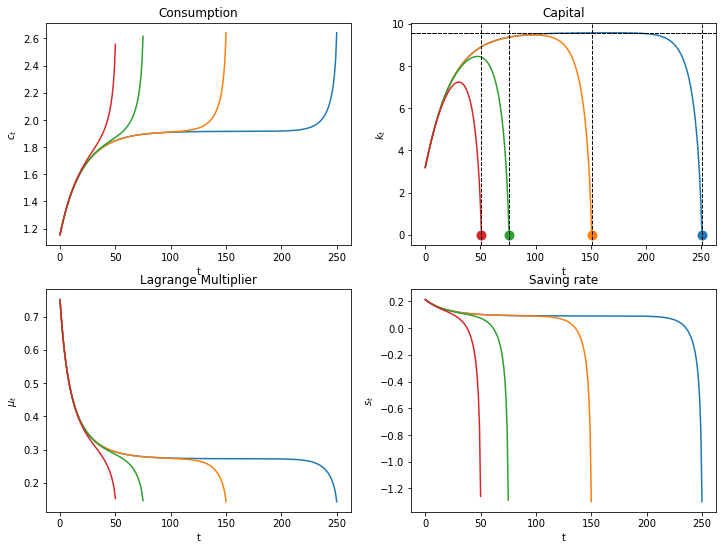

In [18]:
plot_saving_rate(pp, 0.3, k_ss/3, [250, 150, 75, 50], k_ss=k_ss)

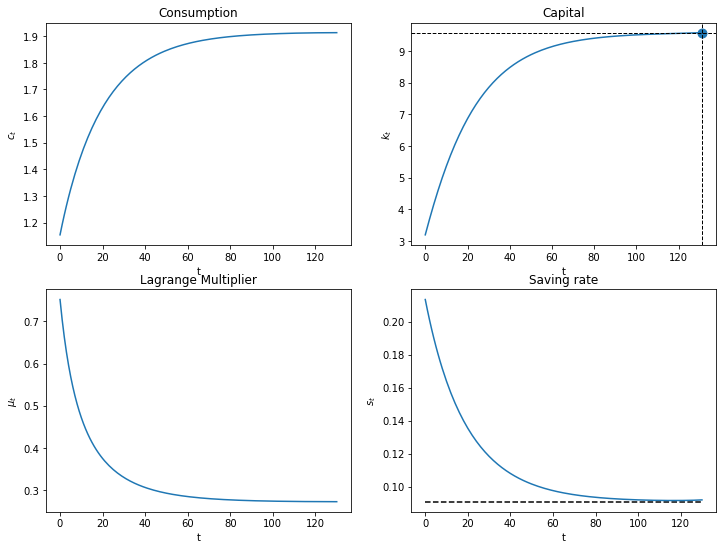

In [19]:
# steady state of saving rate
s_ss = pp.δ * k_ss / pp.f(k_ss)

plot_saving_rate(pp, 0.3, k_ss/3, [130], k_ter=k_ss, k_ss=k_ss, s_ss=s_ss)

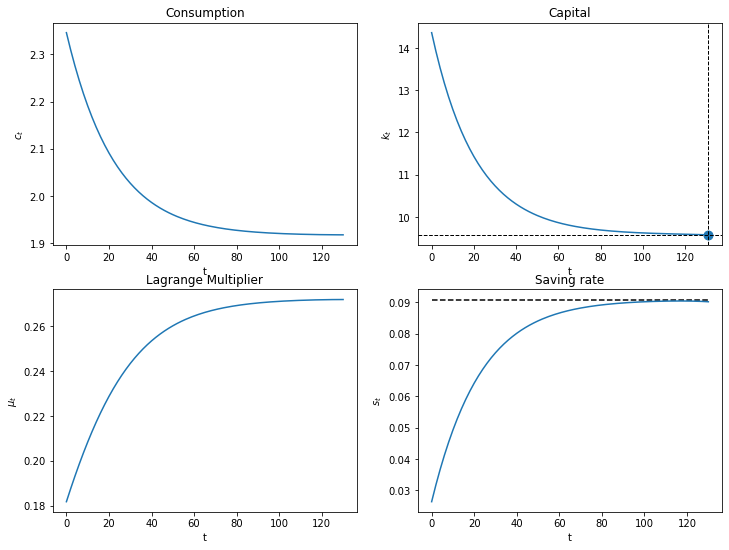

In [20]:
plot_saving_rate(pp, 0.3, k_ss*1.5, [130], k_ter=k_ss, k_ss=k_ss, s_ss=s_ss)